In [44]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath("../CONSTANTS.py")))

import matplotlib.pyplot as plt
import matplotlib.cm as colormap
import pandas as pd
import numpy as np
import seaborn as sns
from utils.confusion_matrix import CM
from utils.cm_generator import CMGenerator
from metrics.tau import Tau
from metrics.tau_weighted import TauW
from metrics.roc import ROC
from metrics.tss import TSS
from metrics.hss import HSS
from metrics.acc import ACC
from metrics.pre import PRE
from metrics.rec import REC
from metrics.fbs import FBS
from metrics.youden import YDN
%matplotlib inline

In [45]:
def calculate_for_all(all_cms, metric):
    """
    calculates the given metric on each of the confusion matrices.
    
    :param all_cms: a list of all confusion matrices.
    :param metric: the metric whose values are of interest.
    
    :return: a list of all calculated values.
    """
    all_vals = []
    for cm in all_cms:
        m = metric(cm)
        all_vals.append(m.value)
    return all_vals

#### Generate a set of learningly increasing imbalance ratios:

In [46]:
n_ps = [100, 100, 100, 100, 100, 100, 100, 100, 100]
n_ns = [100, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200]

space_w = 15

cm_collection = []
imbalance_ratios = []
for n_p, n_n in zip(n_ps, n_ns): 
    imbalance_ratios.append(n_n / n_p)
    gen = CMGenerator(2, n_p+n_n, {'t': n_p, 'f': n_n})
    gen.generate_cms(15)
    cm_collection.append(gen.all_cms)

#### Calculate All Sensitivies on All Spaces, Per Metric

In [47]:
all_norms = {}
all_metrics = [ACC, PRE, REC, FBS, TSS, HSS, YDN, ROC, Tau]
all_metrics = [ACC]
for metric in all_metrics:
    
    cm_0 = cm_collection[0]
    vals = calculate_for_all(cm_0, metric)
    vals_as_mat_0 = np.flip(np.array(vals).reshape((space_w, space_w)), 0)
    metric_norms = []
    for idx, cm in enumerate(cm_collection):
        vals = calculate_for_all(cm, metric)
        vals_as_mat = np.flip(np.array(vals).reshape((space_w, space_w)), 0)
        
        
        #pairwise distance between no imbalance and imbalance
        diff = vals_as_mat - vals_as_mat_0
        print(np.sum(np.abs(diff)))
        metric_norms.append(np.sum(np.abs(diff)))

    all_norms.update({metric.__name__: metric_norms})
    

0.0
24.052
31.15777777777778
33.90615384615384
35.35176470588235
36.254285714285714
36.86000000000001
37.30275862068966
37.63454545454546


#### Normalize the Norms

In [48]:
for met in all_metrics:
    d = 1
    if met.__name__ in ['TSS', 'HSS']:
        d = 2
    m = all_norms[met.__name__]
    all_norms.update({met.__name__: list(np.array(m) / (space_w * space_w * d))})

print(metric_norms)
print(all_norms)

[np.float64(0.0), np.float64(24.052), np.float64(31.15777777777778), np.float64(33.90615384615384), np.float64(35.35176470588235), np.float64(36.254285714285714), np.float64(36.86000000000001), np.float64(37.30275862068966), np.float64(37.63454545454546)]
{'ACC': [np.float64(0.0), np.float64(0.10689777777777777), np.float64(0.13847901234567903), np.float64(0.15069401709401709), np.float64(0.157118954248366), np.float64(0.16113015873015873), np.float64(0.16382222222222226), np.float64(0.16579003831417627), np.float64(0.16726464646464648)]}


#### Plot Them All

C:\Users\Colin\AppData\Local\Temp\ipykernel_30948\3551407062.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = colormap.get_cmap('tab20b', 12)


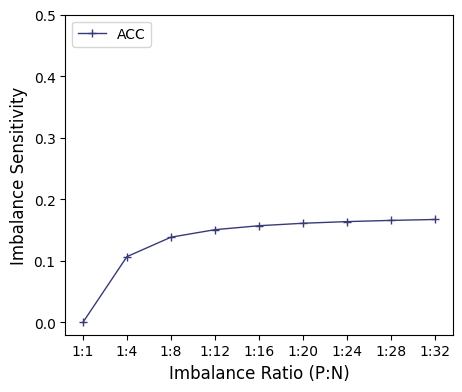

In [49]:
all_labels = ['{}'.format(m.__name__) for m in all_metrics]

viridis = colormap.get_cmap('tab20b', 12)
colors = viridis(range(12))
markers = ['+', 'o', 'v', '1', 'x', '8', '.', 'p', '2']
i = 0
fig, ax = plt.subplots(figsize=(5, 4))
for metric, norms in all_norms.items():
    ax.plot(norms, color = colors[i], marker=markers[i], linewidth=1, label=all_labels[i])
    i = i + 1

# plt.xticks(np.arange(0,9), np.arange(1,10))
x_ticks = ['{}:{}'.format(1, int(r)) for r in imbalance_ratios]
plt.xticks(np.arange(0,9), x_ticks)  #, rotation=30
plt.ylim(-0.02, 0.50)

ax.set_xlabel('Imbalance Ratio (P:N)', fontsize=12)
ax.set_ylabel('Imbalance Sensitivity', fontsize=12)
    
fig.subplots_adjust(wspace=0.05, hspace=0.3, top=0.95, bottom=0.15)
plt.legend(loc='upper left')

IndexError: list index out of range

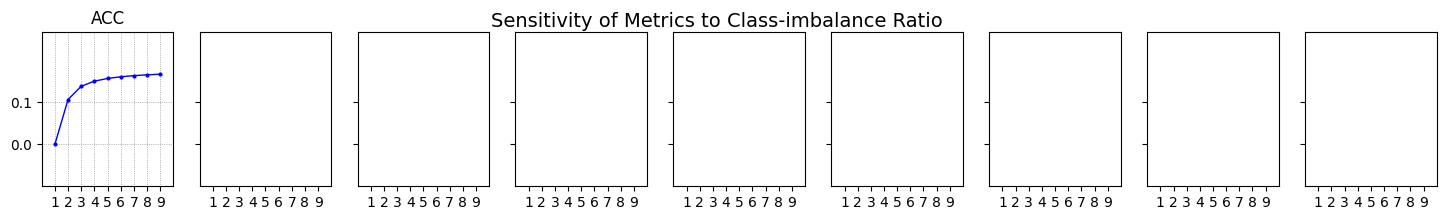

In [50]:
x = np.arange(1, 10)
max_norm = np.max([max(norms) for norms in all_norms.values()])

all_titles = ['{}'.format(m.__name__) for m in all_metrics]

fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(18, 2), sharex=True, sharey=True)
fig.suptitle('Sensitivity of Metrics to Class-imbalance Ratio', fontsize=14)
for idx, ax in enumerate(axs.flat):
    ax.plot(x, all_norms[all_metrics[idx].__name__], color='blue', marker='o', markersize=2, linewidth=1)
    ax.set_xlim(0,10)
    ax.set_xticks(np.arange(1,10))
    ax.set_ylim(-0.1, max_norm + 0.1)
    ax.set_yticks(np.arange(0, max_norm, 0.1))
    ax.set_title(all_titles[idx])    
    ax.grid(linestyle='dotted', linewidth='0.5', color='grey')
    
for ax in axs.flat:
    ax.set_xlabel('Imbalance Ratio', fontsize=12)
    ax.set_ylabel('Sensitivity', fontsize=12)

for ax in axs.flat:
    ax.label_outer()
fig.subplots_adjust(wspace=0.05, hspace=0.3, top=0.7)